# BiGAN_on_MVTec_with_bottle_class

This is the second part for the work with GANs, please don't start it before finishing the AnoGAN (DCGAN) part, as this part is not finished yet.

### 0. Getting Datab (This part is the same as in the AnoGAN architecture)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#%cd /content/drive/MyDrive/Projet_IA_2023

In [ ]:
!pip install fastai==1.0.61
!pip install jupyter
!pip install matplotlib
!pip install wget
!pip install kornia
!pip install opencv-python


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 2.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.1/354.1 kB 6.3 MB/s eta 0:00:00ta 0:00:01
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19171 sha256=d5e9b607c795b9d99a06f96defc73d300fe1493df04ecf1b5ae9b31d004779fe
  Stored in directory: /root/.cache/pip/wheels/5c/d8/c0/46899f8be7a75a2ffd197a23c8797700ea858b9b34819fbf9e
Successfully built nvidia-ml-py3
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.14
    Uninstalling fastai-2.7.14:
      Successfully uninstalled fastai-2.7.14
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=43d6ec180618bcd01137bb5e8bd1da983b00b839895d7411f61e191e75490e6c
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import sys, wget, tarfile, os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import kornia
from fastai.vision import *
import warnings
warnings.filterwarnings('ignore')

We will be using in this colab, the Bottle Class.

In [ ]:
data_path=Path("/kaggle/input/bottle")
dset='bottle'

In [ ]:
list((data_path/dset/'train').glob('*'))
im_paths=list((data_path/dset/'train'/'good').glob('*'))
len(im_paths) #How many examples do we have? (We have 209 images for the train)

209

In [ ]:
# The test folder has a bit more going on, and includes examples of a 3 defect
# classes, and some more good examples to use in testing.
list((data_path/dset/'test').glob('*'))

[PosixPath('/kaggle/input/bottle/bottle/test/good'),
 PosixPath('/kaggle/input/bottle/bottle/test/contamination'),
 PosixPath('/kaggle/input/bottle/bottle/test/broken_large'),
 PosixPath('/kaggle/input/bottle/bottle/test/broken_small')]

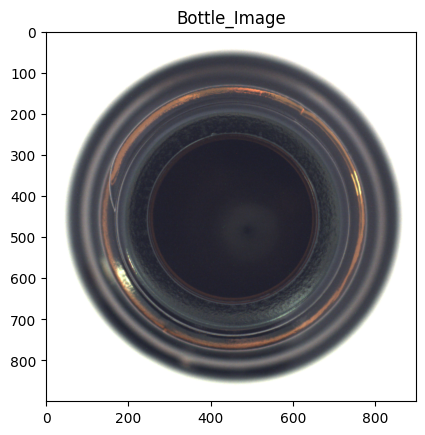

In [ ]:
plt.imshow(plt.imread(str(im_paths[0])))
plt.title('Bottle_Image');

Now, we'll create a a dataloader that will return minibatches of size 128, downsample our images to 64x64. The databunch from the fastai library will take care of data augmentation and normalization.

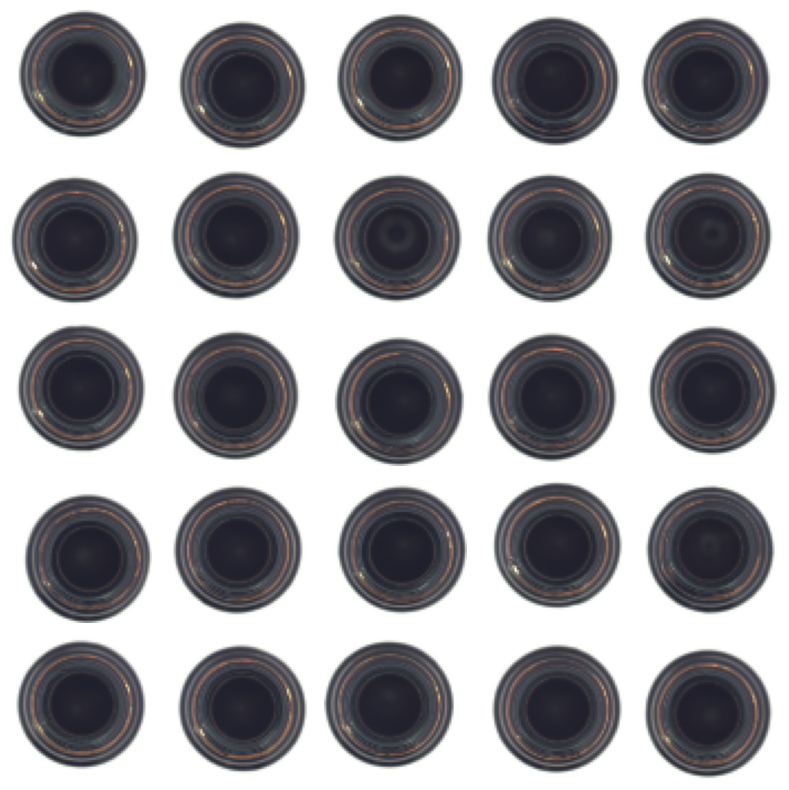

In [ ]:
batch_size, im_size, channels = 64, 64, 3
tfms = ([*rand_pad(padding=3, size=im_size, mode='border')], [])
data = ImageList.from_folder(data_path/dset/'train'/'good').split_none() \
                                                                .label_empty() \
                                                                .transform(tfms, size=im_size) \
                                                                .databunch(bs=batch_size) \
                                                                .normalize((0.5, 0.5))

data.show_batch(figsize=(8, 8))

Let's have a quick look at the scale of the data.

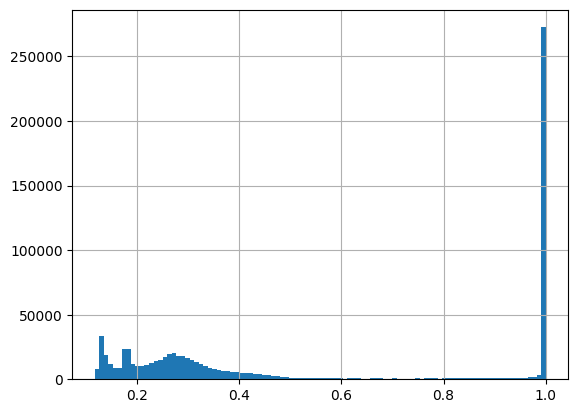

In [ ]:
# Our GAN needs to learn to imitate this distribution.

x, y=data.one_batch()
plt.hist(x.numpy().ravel(),100); plt.grid(1)

### 1. Training

In this part we will define a new structure of GAN which involves an encoder in the architecture

We will be modifying the show progress function to visualize the training of the encoder by visualizing the change in the disctribution of E(x) after each epochs.

We do know that Encoders converge when The Generator converges as they are deeply related.

In [ ]:
def show_progress(epoch, losses, x, z_fixed, E, G, save=False):
    '''Visualization method to see how we're doing'''
    plt.clf()
    fig=plt.figure(0, (24, 12))
    gs=gridspec.GridSpec(6, 12)

    # Generate fake images
    with torch.no_grad():
        fake = G(z_fixed)

    # Obtain encoded representations of input images
    z_encoded = E(x)

    # Display generated images
    for j in range(30):
        fig.add_subplot(gs[(j//6), j%6])
        plt.imshow((kornia.tensor_to_image(fake[j])+1)/2)
        plt.axis('off')

    # Display histograms of fake images
    ax=fig.add_subplot(gs[5, :4])
    plt.hist(fake.detach().cpu().numpy().ravel(), 100, facecolor='xkcd:crimson')
    ax.get_yaxis().set_ticks([])
    plt.xlabel('$G(z)$', fontsize=16)
    plt.xlim([-1, 1])

    # Display histograms of encoded representations
    ax=fig.add_subplot(gs[5, 4:7])
    plt.hist(z_encoded.detach().cpu().numpy().ravel(), 100, facecolor='xkcd:purple')
    ax.get_yaxis().set_ticks([])
    plt.xlabel('$E(x)$', fontsize=16)

    # Plot loss curves
    fig.add_subplot(gs[:,7:])
    plt.plot(losses[0], color='xkcd:goldenrod', linewidth=2)
    plt.plot(losses[1], color='xkcd:sea blue', linewidth=2)
    plt.legend(['Discriminator', 'Generator'],loc=1, fontsize=16)
    plt.grid(1)
    plt.title('Epoch = ' + str(epoch), fontsize=16)
    plt.ylabel('loss', fontsize=16)
    plt.xlabel('iteration', fontsize=16)

    # Display the visualization
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [ ]:
#Here we redefine the GAN with the encoder architecture

rom torch import optim
from tqdm import tqdm
from IPython import display
import matplotlib.gridspec as gridspec

save_training_viz=True


data_path=Path("/kaggle/input/hazelnut")
dset='hazelnut'

batch_size, im_size, channels = 64, 64, 3
tfms = ([*rand_pad(padding=3, size=im_size, mode='border')], [])
data = ImageList.from_folder(data_path/dset/'train'/'good').split_none() \
                                                            .label_empty() \
                                                            .transform(tfms, size=im_size) \
                                                            .databunch(bs=batch_size) \
                                                            .normalize((0.5, 0.5))

x, y = data.one_batch()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def conv_trans(ni, nf, ks=4, stride=2, padding=1):
    return nn.Sequential(
        nn.ConvTranspose2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=padding),
        nn.BatchNorm2d(nf),
        nn.ReLU(inplace=True))

def conv(ni, nf, ks=4, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=padding),
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(0.2, inplace=True))

G = nn.Sequential(
    conv_trans(100, 1024, ks=4, stride=1, padding=0),
    conv_trans(1024, 512),
    conv_trans(512, 256),
    conv_trans(256, 128),
    nn.ConvTranspose2d(128, channels, 4, stride=2, padding=1),
    nn.Tanh()).to(device)

E = nn.Sequential(
    conv(3, 128),
    conv(128, 256),
    conv(256, 512),
    conv(512, 1024),
    nn.Conv2d(1024, 100, 4, stride=1, padding=0),
    Flatten(),
).to(device)

D = nn.Sequential(
    conv(channels + 100, 128),
    conv(128, 256),
    conv(256, 512),
    conv(512, 1024),
    nn.Conv2d(1024, 1, 4, stride=1, padding=0),
    Flatten(),
    nn.Sigmoid()).to(device)

optD = optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))
optG = optim.Adam(list(G.parameters()) + list(E.parameters()), lr=1e-4, betas=(0.5, 0.999))
criterion = nn.BCELoss()


Here we triied to train the new architecture which is the Bidirectional GAN. One of the problems we met, is the tuning of th hyperparameters. At first we decided to use the same hyperparameters as in the DCGAN architecture, however that revealed to be inefficient as the architecture couldn't converge using these parameters. After some trials, we suggest to use a a bigger learning rate for the optimizer of the Discriminator than the learning rate for the optimizer of the Generator and the encoder.

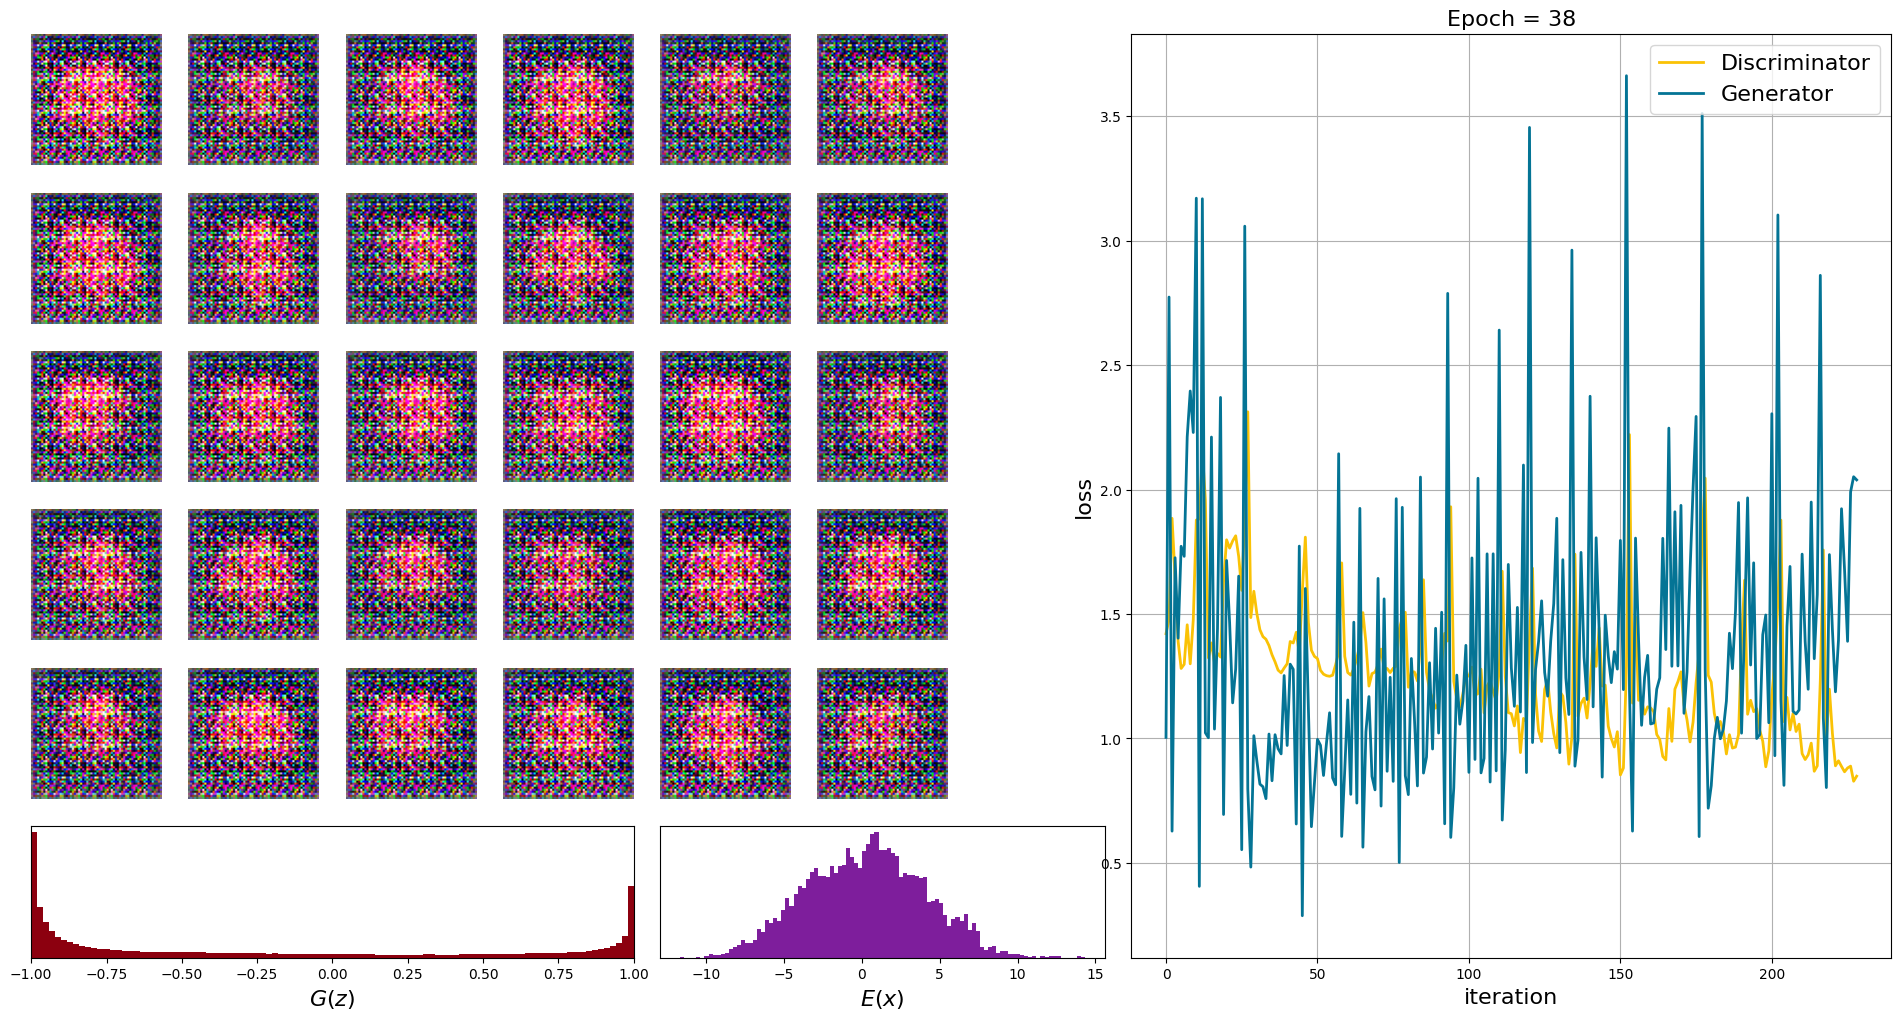

In [ ]:
zero_labels = torch.zeros(batch_size,1).to(device)
ones_labels = torch.ones(batch_size,1).to(device)
losses = [[], []]
epochs, viz_freq, save_freq, count = 500, 100, 50, 0
z_fixed = torch.randn(batch_size, 100, 1, 1).to(device)

for epoch in range(epochs):
    for i, (x, y) in enumerate(data.train_dl):
        # Train Discriminator
        requires_grad(G, False)
        requires_grad(E, False)
        z = torch.randn(batch_size, 100, 1, 1).to(device)
        z_encoded = E(x)
        z_encoded = z_encoded.view(batch_size, 100, 1, 1)
        fake_input = torch.cat((G(z), z_encoded.expand(-1, -1, im_size, im_size)), dim=1)
        l_fake = criterion(D(fake_input), zero_labels)
        real_input = torch.cat((x, z_encoded.view(batch_size, 100, 1, 1).expand(-1, -1, im_size, im_size)), dim=1)
        l_real = criterion(D(real_input), ones_labels)
        loss_D = l_fake + l_real
        loss_D.backward()
        optD.step()
        losses[0].append(loss_D.item())
        optD.zero_grad()
        optG.zero_grad()

        # Train Generator and Encoder
        requires_grad(G, True)
        requires_grad(E, True)
        z = torch.randn(batch_size, 100, 1, 1).to(device)
        z_encoded = E(x)
        z_encoded = z_encoded.view(batch_size, 100, 1, 1)
        fake_input = torch.cat((G(z), z_encoded.expand(-1, -1, im_size, im_size)), dim=1)
        loss_GE = criterion(D(fake_input), ones_labels)
        loss_GE.backward()
        optG.step()
        losses[1].append(loss_GE.item())
        optG.zero_grad()
        optD.zero_grad()

        if i % viz_freq == 0:
            show_progress(epoch, losses, x, z_fixed, E, G, save=save_training_viz)
        count += 1